# 编程练习4：神经网络学习
这次还是解决手写数字识别的问题。ex3中我们使用了已经训练好的神经网络，得到了比逻辑回归更好的效果。ex4我们自己来训练神经网络。
## 1 神经网络
### 1.1 数据可视化
这部分ex3已做过。唯一需要注意的，是将y用one-hot编码时，pandas的get_dummies函数的使用。具体说明见http://blog.csdn.net/mvpboss1004/article/details/79188190

In [2]:
%matplotlib inline
import numpy as np
from scipy.io import loadmat
from random import sample
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit
from operator import mul, add
from functools import reduce
from sklearn.metrics import mean_squared_error

In [3]:
raw_data = loadmat('ex4data1.mat')
X = np.mat(raw_data['X'])
y = np.mat(pd.get_dummies(raw_data['y'].flatten())).astype(np.float)
raw_theta = loadmat('ex4weights.mat')
Theta1 = raw_theta['Theta1']
Theta2 = raw_theta['Theta2']
m = len(y)

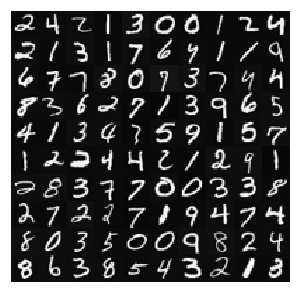

In [4]:
fig = plt.figure(figsize=(5,5))
sample_num = 100
idx = sample(range(0,m), sample_num)
for i in range(0, sample_num):
    plt.subplot(10, 10, i+1)
    plt.imshow(X[idx[i],:].reshape((20,20)).T, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### 1.3 前向传播及代价函数
神经网络代价函数表示为：  
$$J(\theta)=\frac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}[-y_k^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y_k^{(i)})log(1-(h_\theta(x^{(i)}))_k)]$$  
这里y是一个one-hot的矩阵，因此$h_\theta(X)$和y都是m*K的。我们可以用矩阵表示为：  
$$J(\theta)=\frac{1}{m}\sum[-y.*log(h_\Theta(X))-(1-y).*log(1-h_\Theta(X))]$$
注意，这里点乘表示对应元素相乘

In [5]:
def split_line_by_shape(line, shapes):
    start = 0
    mtx = []
    for shape in shapes:
        size = reduce(mul, shape, 1)
        mtx.append(np.mat(line[start:start+size]).reshape(shape))
        start += size
    return mtx
def join_mtx(mtx):
    return reduce(add, [m.flatten().tolist() for m in mtx], [])

def cost(thetas, *args):
    a, y, shapes = args
    start = 0
    for theta in split_line_by_shape(thetas, shapes):
        a = np.column_stack([np.ones((len(a),1)), a])
        z = a * theta.T
        a = expit(z)
    J = np.sum(np.multiply(-y, np.log(a)) - np.multiply(1-y, np.log(1-a))) / len(y)
    return J

shapes = [Theta1.shape, Theta2.shape]
thetas = join_mtx([Theta1,Theta2])
print('Cost: %s\tExpected: 0.287629' % cost(thetas, X, y, shapes))

Cost: 0.287629165161	Expected: 0.287629


### 1.4 正则化代价函数
有了之前的基础，我们可以很快写出矩阵形式表示的正则化代价函数：  
$$J(\theta)=\frac{1}{m}\sum[-y.*log(h_\Theta(X))-(1-y).*log(1-h_\Theta(X))]+\frac{\lambda}{2m}\Theta^{*T}\Theta^{*}$$
注意，这里的$\Theta^*$，是把每一层的theta的偏置项置0。

In [6]:
def costReg(thetas, *args):
    X, y, shapes, lamda = args
    Thetas = np.mat(thetas)
    idx = 0
    for shape in shapes:
        for i in range(0,shape[0]):
            Thetas[0,idx] = 0
            idx += shape[1]
    J = cost(thetas, X, y, shapes) + lamda/(2*len(y))*Thetas*Thetas.T
    return J[0,0]
lamda = 1
print('Cost: %s\tExpected: 0.383770' % costReg(thetas, X, y, shapes, lamda))

Cost: 0.383769859091	Expected: 0.383770


## 2 反向传播
这里其实还是用梯度下降法求解。只要能将梯度表示出来，就能求解。这个和之前的思路是一样的。
### 2.2 随机初始化

In [7]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = np.sqrt(6.0 / (L_in+L_out))
    return np.random.rand(L_out, 1+L_in)*2*epsilon_init - epsilon_init
print(randInitializeWeights(2,3))

[[-0.95107824  0.6930462   0.27724781]
 [-0.49513076  0.90533784 -0.26085458]
 [ 0.282365   -0.36361899  0.43509072]]


### 2.3 反向传播
反向传播实现起来会比正向麻烦一些。因为正向传播不需要保留上一次迭代的信息，一直原地替换就完了。  
练习中是实现固定层数（3层）的反向传播。为了更好理解，我们实现任意层数的。
推倒的公式看起来很复杂，但最关键的一步是理解：  
$$\Delta^{(l)}:=\Delta^{(l)}+\delta_k^{(l+1)}(a_k^{(l)})^T$$
假如大家熟悉矩阵分块运算，设：
$$\delta^{(l+1)}=\begin{bmatrix}
\delta_1^{(l+1)T}\\
\delta_2^{(l+1)T}\\
...\\
\delta_m^{(l+1)T}
\end{bmatrix}, a^{(l)}=\begin{bmatrix}
a_1^{(l)T}\\
a_2^{(l)T}\\
...\\
a_m^{(l)T}
\end{bmatrix}$$
则  
$$D^{(l)}=\frac{1}{m}[\delta_1^{(l+1)}a_1^{(l)T}+\delta_2^{(l+1)}a_2^{(l)T}+...+\delta_m^{(l+1)}a_m^{(l)T}]=\frac{1}{m}\delta^{(l+1)T}*a^{(l)}$$
而其中
$$\delta^{(l)}=\Theta^{(l)T}\delta^{(l+1)}.*[a^{(l)}.*(1-a^{(l)})]$$

In [8]:
def grad(thetas, *args):
    a, y, shapes = args
    A = [a]
    thetas = split_line_by_shape(thetas, shapes)
    for theta in thetas:
        a = np.column_stack([np.ones((len(a),1)), a])
        z = a * theta.T
        a = expit(z)
        A.append(a)
    D = [0]*len(shapes) + [A[-1] - y]
    G = []
    for i in range(len(shapes)-1,-1,-1):
        D[i] = np.multiply((D[i+1]*thetas[i])[:,1:], np.multiply(A[i],1-A[i]))
        G += (D[i+1].T*A[i+1]).flatten().tolist()
    return G

### 2.4 梯度校验
梯度校验可用于检查梯度计算是否正确。

In [10]:
def numGrad(thetas, *args):
    epsilon = 1e-4
    thetas = np.array(thetas)
    numgrad = np.zeros(len(thetas))
    perturb = np.zeros(len(thetas))
    for p in range(0,len(thetas)):
        perturb[p] = epsilon
        loss1 = cost(thetas-perturb, *args)
        loss2 = cost(thetas+perturb, *args)
        numgrad[p] = (loss2 - loss1) / (2*epsilon)
        perturb[p] = 0
        print(p, numgrad[p])
    return numgrad.tolist()
g1 = grad(thetas, X, y, shapes)
g2 = numGrad(thetas, X, y, shapes)
print(type(g1))

0 6.18712781009e-05
1 0.0
2 0.0
3 4.15306677937e-09
4 -5.29870591848e-08
5 1.42184042318e-07
6 1.59715296544e-06
7 -8.89999740572e-07
8 -1.45513073813e-06
9 -4.08953426678e-07
10 3.44129169605e-07
11 1.37932165689e-07
12 -3.05399872058e-07
13 -6.73015532193e-07
14 -2.2870483285e-07
15 -2.70443667461e-07
16 -7.62717666802e-08
17 -8.25511881075e-08
18 -6.54920562226e-09
19 1.27425847651e-09
20 0.0
21 -1.22124532709e-11
22 2.85049761573e-10
23 -4.86047313508e-08
24 4.52474169244e-07
25 2.73948086438e-07
26 -1.27495430879e-06
27 -5.61283547418e-06
28 -9.10609698757e-06
29 -4.45816911165e-06
30 -4.69067312769e-06
31 -4.38439284878e-07
32 5.18534493121e-06
33 8.22104301301e-06
34 1.35343986019e-06
35 1.4950549132e-06
36 7.77077013847e-07
37 -4.260480857e-10
38 -2.12913159325e-06
39 -1.97012683945e-07
40 6.24691964823e-08
41 1.43218770177e-10
42 -1.03636543791e-08
43 -2.38426223209e-07
44 2.43105563458e-06
45 1.40460187925e-05
46 2.58602395053e-05
47 1.36963354547e-05
48 -2.96137869782e-05
49

378 -1.19985965608e-07
379 3.56831508785e-07
380 4.34119407089e-08
381 0.0
382 3.10679260096e-08
383 -2.65910349295e-07
384 -1.93639188018e-06
385 1.41302425316e-05
386 1.69436376041e-05
387 8.04329575166e-06
388 2.80947570763e-06
389 7.48132000794e-06
390 -1.76519354689e-07
391 -2.49431308941e-07
392 -2.59714638684e-06
393 -1.0988057686e-06
394 5.4094054236e-06
395 5.39296662883e-07
396 -1.25175703136e-06
397 -3.73277520005e-07
398 9.70112878917e-09
399 2.85521606358e-09
400 0.0
401 9.38798150329e-05
402 0.0
403 0.0
404 -6.50868248186e-10
405 3.89605014917e-09
406 1.99426586356e-08
407 3.0853514188e-07
408 5.92456639303e-07
409 6.2560651104e-07
410 -7.6770534374e-08
411 -1.56346380287e-06
412 -4.90112950224e-07
413 2.76532963195e-07
414 4.1533720907e-07
415 -4.69079497467e-07
416 3.14329118289e-08
417 1.22290511051e-07
418 1.46910261734e-08
419 -7.64110996698e-10
420 -1.12410081243e-10
421 0.0
422 -2.77555756156e-12
423 -1.05471187339e-09
424 1.90292226421e-08
425 -1.12772291505e-07
4

749 -1.10670264619e-05
750 7.08377578817e-06
751 2.92684829151e-05
752 5.71327327115e-05
753 5.7575762491e-05
754 5.78135475604e-05
755 9.12174616396e-05
756 4.39445863032e-05
757 4.19272905283e-05
758 7.40314920478e-06
759 2.96456192928e-07
760 -7.92589799348e-06
761 -1.35175814986e-06
762 -1.4155343564e-11
763 4.24088542061e-08
764 1.39336681082e-06
765 -1.14344650415e-05
766 -2.39537917279e-05
767 -5.74078745652e-05
768 -9.93865198473e-05
769 -9.51349921063e-05
770 -5.17186971027e-05
771 -6.43897435371e-07
772 1.66295793802e-05
773 1.09783199198e-05
774 6.17635415034e-06
775 -9.3863761208e-06
776 5.36364286319e-07
777 1.16276710482e-05
778 2.1529611427e-06
779 5.10011477495e-08
780 7.64319163515e-07
781 3.66456864853e-09
782 0.0
783 -3.74728026387e-09
784 4.28515556372e-08
785 -4.66898186779e-07
786 8.88914941655e-06
787 5.0484844083e-06
788 -4.82553580428e-06
789 -3.90424081953e-06
790 -4.95160829006e-06
791 1.98814936736e-06
792 -2.32512370468e-06
793 2.32754732155e-06
794 7.87268

1117 -5.40640876512e-05
1118 -8.72913125116e-05
1119 -0.000108325181047
1120 9.61554283418e-05
1121 0.000156624712366
1122 7.55114112905e-05
1123 -1.80708226161e-08
1124 1.31164384909e-06
1125 4.83019180209e-08
1126 -7.1266270385e-05
1127 -0.000111514333878
1128 -0.000194928327646
1129 -0.000228967706739
1130 -8.51973416816e-05
1131 2.00419361662e-05
1132 -0.000144456944462
1133 -0.000165312808997
1134 -3.22734752811e-05
1135 -0.000272144090596
1136 -0.000236341279047
1137 -0.000157064675432
1138 -0.000170052606996
1139 -0.000140693572626
1140 2.94759661124e-06
1141 4.0828085357e-05
1142 2.08666001145e-05
1143 4.92911267358e-09
1144 2.81163980986e-09
1145 1.81145348721e-06
1146 -1.74400646702e-05
1147 -0.000187918903216
1148 -0.00035259545339
1149 -0.000366757552384
1150 -0.000216844740497
1151 -0.000139107467767
1152 -0.000154134981167
1153 -7.09886621708e-05
1154 -0.000113660418855
1155 -0.000260697554655
1156 -9.30290225409e-05
1157 3.16680423551e-05
1158 3.36338151774e-06
1159 -9.4

1474 -4.18852913464e-05
1475 -0.000184623565325
1476 2.99165969775e-07
1477 -0.000145468601886
1478 -6.19751908126e-05
1479 -8.46644798713e-05
1480 -0.000169666683481
1481 -7.97415550258e-06
1482 0.000198905583393
1483 5.25574897492e-05
1484 5.27761168101e-08
1485 2.61100557841e-06
1486 -2.90667015457e-05
1487 -0.00019641100496
1488 -0.000241897143982
1489 -8.50100295713e-05
1490 -3.82248860342e-05
1491 7.45849715322e-06
1492 0.000214611352578
1493 9.90477924678e-05
1494 0.000132242856665
1495 -0.000122128207269
1496 -5.79738038131e-05
1497 -0.000103124862261
1498 -6.9277492909e-05
1499 -3.71116778974e-05
1500 -5.37548058843e-05
1501 2.95831245611e-05
1502 0.000119790810049
1503 1.74306435952e-05
1504 -1.01772201777e-07
1505 2.52085213814e-06
1506 -3.95427884881e-06
1507 -0.000158971134867
1508 -0.000336848252624
1509 -0.000221080657947
1510 -0.000142485025167
1511 5.08760156226e-05
1512 0.000158115208981
1513 4.5118038472e-05
1514 5.446611967e-05
1515 -0.000208160525206
1516 -0.000261

1829 -0.000216474309866
1830 -0.000155998098605
1831 -7.45113340472e-05
1832 0.000166750025177
1833 0.000405430929107
1834 3.9234737681e-06
1835 -0.000127793998994
1836 -0.000216883350723
1837 -0.00019709158805
1838 -0.00042280041801
1839 -0.000323298444405
1840 -0.000119136162602
1841 4.71596339757e-05
1842 1.30441799029e-05
1843 -5.05493644165e-05
1844 -2.03047625935e-05
1845 2.64679278494e-06
1846 -2.90948681814e-05
1847 -0.000175964153803
1848 -0.000162183057817
1849 -0.000106731045391
1850 -5.2690449226e-05
1851 7.35690650067e-05
1852 9.1520587775e-05
1853 2.63932475875e-05
1854 -0.000350812085492
1855 -0.000133188038376
1856 -3.47132708689e-05
1857 -0.000138051253207
1858 -0.000184171877193
1859 2.74299166714e-05
1860 -7.0954797593e-05
1861 5.59281454482e-06
1862 -4.63889868185e-05
1863 -4.22119367238e-05
1864 1.89452065147e-06
1865 2.10227474318e-06
1866 -2.68165462058e-05
1867 -0.000149223978452
1868 -3.5416855837e-05
1869 -8.21740259171e-05
1870 3.9316967182e-05
1871 0.0001598

2183 -0.000147704581621
2184 1.68760819208e-05
2185 1.70067043781e-05
2186 -9.16112463667e-07
2187 -1.4745852317e-05
2188 -0.000126148359814
2189 -0.00026123481961
2190 -0.000165114289186
2191 -9.89598103462e-05
2192 -0.000133469311159
2193 1.14945636343e-05
2194 3.04201672185e-05
2195 -0.000122569471239
2196 -0.000147763723202
2197 -0.000247944957066
2198 -2.37259575875e-05
2199 -3.89295692904e-05
2200 -0.00028483362613
2201 -0.000267174494195
2202 -0.000304488879943
2203 -0.000387055765771
2204 -7.35024624499e-05
2205 -1.98576072252e-06
2206 -3.42364470107e-07
2207 -3.88101795146e-05
2208 -0.00018608639657
2209 -0.000335559374176
2210 -0.000135232664233
2211 -3.3268316435e-05
2212 -0.00018022384668
2213 2.09627235015e-05
2214 4.63118729477e-05
2215 -0.000257889431199
2216 -0.000176395630047
2217 -0.00022201383898
2218 0.000220782357951
2219 0.000123130144691
2220 -0.000462539358759
2221 -0.000408373722061
2222 -0.000298609154348
2223 -0.000252498650044
2224 6.22997778366e-05
2225 -1.

2537 -0.000289007513199
2538 -0.000349754649964
2539 7.0793987339e-05
2540 0.000187630171677
2541 0.000121912245021
2542 0.000188501507181
2543 0.00019435575066
2544 0.000174163360955
2545 8.26362719919e-05
2546 1.27508709147e-05
2547 7.76452596662e-06
2548 4.68137170695e-05
2549 4.48526632502e-06
2550 9.8264281434e-05
2551 9.0537783104e-05
2552 0.000229237935023
2553 0.000260519489037
2554 0.000100872764863
2555 5.53834514361e-05
2556 3.87574400351e-05
2557 -5.70294134139e-05
2558 -0.000214735472737
2559 9.40151470563e-05
2560 0.000125288864561
2561 2.11750708634e-05
2562 -3.63119534441e-06
2563 0.000163222099447
2564 0.000160682043504
2565 8.64629198793e-05
2566 9.88913728683e-06
2567 3.30063504306e-06
2568 2.23669741062e-05
2569 -5.48258372035e-05
2570 -3.60345900341e-05
2571 0.000255168169094
2572 0.000289792215225
2573 8.72800651197e-05
2574 2.60596211277e-06
2575 0.000244797586091
2576 0.000183963141942
2577 -1.41303960199e-05
2578 -9.92409945888e-05
2579 1.68014432922e-05
2580 7

2897 -0.000193113981195
2898 -0.000183279796895
2899 8.36324479114e-05
2900 0.000367462391626
2901 0.000374787423041
2902 0.000249534785612
2903 0.000120405985737
2904 4.38297029226e-05
2905 3.67825112035e-05
2906 3.09256517617e-05
2907 5.05929159678e-06
2908 -2.23775331598e-06
2909 -9.29577054221e-06
2910 2.07449474265e-06
2911 1.49875323263e-05
2912 0.000136886288415
2913 0.000329120949938
2914 0.000200341623569
2915 4.18897477816e-05
2916 -0.000148005802336
2917 -0.000243763401686
2918 -0.000260018697129
2919 -0.000164037606831
2920 4.0331273321e-05
2921 0.000417722970381
2922 0.000371910126862
2923 8.62920551681e-05
2924 1.74997860647e-05
2925 0.000106612864648
2926 5.28492738461e-05
2927 9.72792818521e-06
2928 -5.08455610948e-06
2929 -2.22445645237e-05
2930 7.75557867927e-06
2931 9.14149933529e-05
2932 0.000139324580206
2933 0.000211152077767
2934 0.000247170337531
2935 7.05799685363e-05
2936 -0.000211714302756
2937 -0.000201072278827
2938 -0.000199280551505
2939 -0.00035805602483

3255 2.88996498954e-05
3256 1.62894814304e-05
3257 3.78578007831e-05
3258 -1.82447862374e-05
3259 -3.18713475056e-05
3260 -2.44426709428e-05
3261 -2.19762530396e-05
3262 -3.27079224816e-06
3263 2.89315316149e-05
3264 1.45075684799e-05
3265 3.27523591581e-06
3266 3.62311625146e-06
3267 5.28838917102e-07
3268 -5.05513131355e-07
3269 -3.34732241924e-10
3270 -1.37623246133e-08
3271 -8.28656587792e-08
3272 1.97247246314e-06
3273 2.53069010192e-06
3274 2.07878661507e-05
3275 5.25528892625e-05
3276 -1.75660444524e-05
3277 -5.35311978078e-05
3278 -2.74874156769e-05
3279 6.55377782599e-05
3280 2.98183222558e-05
3281 2.17770945721e-05
3282 2.98902239071e-05
3283 2.63408503343e-05
3284 8.5400181371e-06
3285 1.10437062273e-05
3286 4.33170138647e-06
3287 1.82483667066e-06
3288 2.00146815788e-06
3289 -5.16947595841e-09
3290 2.14457895886e-07
3291 -8.15650325059e-06
3292 -7.72613917288e-06
3293 1.28007279776e-05
3294 -2.1601942457e-05
3295 -7.99280103214e-05
3296 -0.000280803437724
3297 -0.0003073871

3605 -8.69321281627e-08
3606 7.12624403931e-09
3607 1.50157664081e-10
3608 0.0
3609 -2.09724046463e-05
3610 0.0
3611 0.0
3612 2.62623256475e-09
3613 -2.30318542016e-08
3614 -3.8716529982e-08
3615 9.44816447301e-08
3616 -2.7239097089e-06
3617 -1.3598799864e-06
3618 -1.45212453173e-07
3619 1.73268621673e-07
3620 2.8605451341e-08
3621 1.75593428686e-07
3622 4.92294260912e-07
3623 8.49134651482e-08
3624 2.19481099961e-07
3625 3.3452518533e-07
3626 6.2542471202e-08
3627 -7.53647144691e-09
3628 -6.41153796721e-11
3629 0.0
3630 -5.55111512313e-13
3631 -7.99915689242e-10
3632 -1.83741910575e-08
3633 2.39756825504e-07
3634 3.90072973921e-07
3635 4.38003189274e-06
3636 -4.33539232292e-06
3637 -5.26369253739e-06
3638 -3.56361995468e-06
3639 -4.48815706822e-06
3640 3.47704920411e-07
3641 -1.59977864289e-06
3642 -6.16324324909e-06
3643 -1.64198876718e-06
3644 -2.40565178888e-06
3645 -3.16317333438e-06
3646 1.36285704944e-07
3647 9.91282611551e-07
3648 1.91701932106e-07
3649 4.28249102846e-08
3650 5

3961 0.000219683602143
3962 0.000223284607748
3963 9.7988871739e-05
3964 5.68566679848e-05
3965 4.49230763699e-05
3966 7.29303784031e-06
3967 -5.75843567274e-06
3968 -1.12450884715e-05
3969 1.269711003e-06
3970 -1.78745906965e-10
3971 1.52663992559e-08
3972 -3.81740472566e-07
3973 2.79360312661e-06
3974 -1.42735828712e-05
3975 -4.01763355917e-05
3976 -1.89866769529e-05
3977 -5.13545872494e-07
3978 4.42159708847e-05
3979 5.83747056249e-05
3980 4.73653910538e-05
3981 0.000142950866699
3982 9.58085927261e-05
3983 6.11166284248e-06
3984 2.37572461703e-06
3985 4.79689704624e-06
3986 -5.02679009529e-07
3987 1.72916680974e-07
3988 7.69344310481e-07
3989 -3.37438410547e-08
3990 0.0
3991 -1.3142265054e-09
3992 -4.91295892857e-08
3993 -2.86586310239e-07
3994 1.54973409106e-05
3995 1.88024992798e-05
3996 1.03235547888e-05
3997 -3.15138221074e-06
3998 2.94945651236e-06
3999 6.42753406055e-06
4000 9.2102997451e-06
4001 2.74502368058e-05
4002 3.77166747834e-05
4003 5.45610306935e-06
4004 -7.45838113

4321 7.94102666957e-05
4322 7.24285459386e-05
4323 0.0001319391979
4324 0.000157282548097
4325 0.000273719343302
4326 0.000182684868899
4327 1.19195256443e-05
4328 2.18818824171e-06
4329 5.61875324046e-06
4330 -2.59234578248e-07
4331 -1.36630706749e-07
4332 2.653331721e-06
4333 -4.55500553942e-06
4334 -9.28723034588e-05
4335 -9.66569643768e-05
4336 -3.46929457384e-05
4337 -9.5554080759e-05
4338 -3.15864887024e-05
4339 -4.1915959037e-05
4340 3.47602643891e-05
4341 7.8647328372e-05
4342 6.46683756544e-05
4343 0.000104492992592
4344 2.92994922768e-05
4345 -5.10437953016e-05
4346 -9.27272306162e-05
4347 -1.69159686259e-05
4348 1.02108621558e-05
4349 -9.47385919714e-06
4350 -5.12927644802e-06
4351 -2.26066665387e-07
4352 2.14939649412e-06
4353 1.13897341558e-05
4354 1.870778088e-05
4355 -0.000113284510939
4356 -0.000224449422381
4357 -0.0002307086297
4358 -9.15477788022e-05
4359 -6.88570378493e-05
4360 1.93234236945e-05
4361 2.59623345045e-05
4362 0.000138551100037
4363 0.000119251406805
43

4676 0.000267958632505
4677 0.00021280325363
4678 0.00034142424471
4679 0.000281932687196
4680 0.000119895472162
4681 3.69600761108e-05
4682 6.81549872095e-06
4683 0.000132815647369
4684 8.66462621096e-05
4685 3.72811781446e-05
4686 -1.03128913742e-05
4687 -5.83294884615e-05
4688 0.000119248403652
4689 7.54545509407e-05
4690 7.97754307058e-06
4691 -1.01634253791e-05
4692 2.35047592501e-06
4693 -4.12643588743e-05
4694 -7.9642692441e-05
4695 4.17696455202e-05
4696 0.000215596269726
4697 7.5052902504e-05
4698 -0.000109881921895
4699 -2.33670860439e-05
4700 9.29979532271e-05
4701 -4.69516370227e-07
4702 2.9476817931e-05
4703 3.73060898839e-05
4704 5.44799821922e-05
4705 3.23035628802e-05
4706 -0.000116475362688
4707 5.18016038398e-05
4708 6.61087851128e-06
4709 -1.73711561802e-05
4710 2.94471944051e-05
4711 -7.13533399033e-07
4712 1.03729580481e-06
4713 -2.04280228844e-05
4714 -3.48977283182e-05
4715 5.27300758613e-06
4716 0.000100330148634
4717 0.0001014968945
4718 -3.18380424802e-05
4719

5032 -1.33906927213e-05
5033 -8.64978172421e-06
5034 -2.67301208945e-05
5035 -0.000183194445724
5036 -0.000180720672871
5037 1.8208337893e-05
5038 0.000178075083568
5039 0.000233512111869
5040 0.000140602328114
5041 -2.89396431818e-05
5042 -3.93166366131e-05
5043 4.24777601982e-05
5044 4.83115225602e-05
5045 0.000128912366892
5046 6.87043397174e-05
5047 -5.3505636588e-05
5048 -9.27389559591e-05
5049 1.37559064139e-05
5050 0.000125699203546
5051 2.7547015502e-05
5052 1.37764133434e-06
5053 2.95320129462e-06
5054 -6.44154282692e-05
5055 -0.000124410396152
5056 -0.000179611682194
5057 -2.05312786217e-05
5058 0.000349663694665
5059 0.00030180611732
5060 0.000256036334634
5061 1.87268983654e-05
5062 -0.000143375226414
5063 4.99338403959e-06
5064 4.94157956221e-05
5065 0.000118809380945
5066 -0.000229589432743
5067 -0.000125072397439
5068 -0.00017531029961
5069 4.27566854144e-05
5070 6.15756670652e-05
5071 -9.08990382964e-06
5072 1.64528612956e-06
5073 2.5096513756e-06
5074 -3.0953649921e-05

5390 0.000159946875466
5391 -1.02130265356e-05
5392 -0.000101363587801
5393 -2.77302653062e-05
5394 1.41786499208e-06
5395 9.92373766495e-06
5396 -9.64843388518e-05
5397 -0.000257807792059
5398 0.000164583283391
5399 5.18688655915e-05
5400 -9.59739790418e-05
5401 0.00017230086774
5402 0.000141083210392
5403 0.000115122631428
5404 1.6010714976e-05
5405 -0.000190761910435
5406 -0.000166477190089
5407 -0.0001696168625
5408 2.29321253653e-05
5409 0.000255808527139
5410 0.000203000248555
5411 -0.000154125687213
5412 -4.63507784931e-05
5413 -3.01541408509e-05
5414 -2.2264856625e-07
5415 5.18548567974e-05
5416 1.83402429355e-05
5417 -0.000156506019811
5418 0.000105063882316
5419 0.000101264588104
5420 2.81510659228e-05
5421 -7.89879511798e-05
5422 -0.000283976374915
5423 -9.97518811996e-05
5424 -0.00027378540518
5425 -0.000328237620417
5426 -0.000116176290255
5427 -0.000265572106528
5428 -0.000335843948207
5429 -5.98209229374e-05
5430 -3.79965481301e-05
5431 3.5556937672e-05
5432 8.3661268746

5746 0.000559146772217
5747 0.000333263042718
5748 8.83295683818e-05
5749 5.26612253804e-05
5750 -8.50284992415e-05
5751 -8.30702634458e-05
5752 3.13052395118e-05
5753 -3.94347740573e-05
5754 -2.5952139604e-05
5755 -6.98469060367e-09
5756 1.2368325808e-06
5757 1.81430567792e-05
5758 -6.2239244869e-05
5759 -3.04364738968e-05
5760 -0.000124776714239
5761 -0.000182738935095
5762 -0.000138600947386
5763 3.23473478558e-05
5764 0.000294544301727
5765 0.00054383021808
5766 0.000310668113734
5767 6.52431134118e-05
5768 -7.28708396402e-05
5769 -0.000238421158927
5770 -0.000153192449559
5771 2.52756565677e-05
5772 1.48643602982e-05
5773 -2.56855753333e-05
5774 -4.24079540928e-05
5775 5.29876698074e-07
5776 -5.84299497675e-06
5777 1.37989314419e-05
5778 -5.23446347378e-05
5779 -4.48007234088e-05
5780 -0.000203904650664
5781 -0.000243723565219
5782 -6.99421748296e-05
5783 0.000304321231548
5784 0.000684037405607
5785 0.000347752242835
5786 -0.000189931758932
5787 -0.000229765820259
5788 -7.7305944

6106 -0.000287762489115
6107 -0.000262141257312
6108 -3.02724759149e-05
6109 9.94812757171e-05
6110 0.000247289827227
6111 0.000240905795312
6112 3.86260259888e-05
6113 -6.00357735747e-05
6114 -6.98400620669e-05
6115 -1.63590030411e-06
6116 -2.40574976607e-06
6117 -1.45584425071e-05
6118 -2.12203399297e-05
6119 1.66464145246e-05
6120 8.97804325328e-05
6121 0.000151502175805
6122 0.000141681299748
6123 -2.24735832721e-05
6124 -0.000265372822328
6125 -0.000232595823435
6126 -0.000191839312769
6127 -0.000161963832901
6128 -0.000145230880377
6129 9.11911324231e-05
6130 0.000265419945744
6131 0.000174680369058
6132 4.42661612921e-05
6133 -2.44858455734e-05
6134 -9.40639099944e-05
6135 -4.79820350119e-06
6136 -8.48874748272e-06
6137 -4.40352568298e-05
6138 -2.36257841069e-05
6139 4.37132385844e-05
6140 8.91756068988e-05
6141 0.000130600618931
6142 1.30993191294e-05
6143 -0.000118403630789
6144 -0.000300811100751
6145 -8.88843024183e-05
6146 -3.04545530461e-05
6147 -0.000130657938913
6148 -0.

6459 3.32883720588e-07
6460 -1.16054943433e-06
6461 -2.39838371385e-05
6462 -6.31121829797e-05
6463 -5.67772956428e-05
6464 -0.000126054799932
6465 -8.38043456852e-05
6466 -2.52640477982e-05
6467 -2.97712132724e-06
6468 -1.05667383177e-05
6469 -2.90043547513e-05
6470 -4.39142905373e-05
6471 -3.4808695093e-05
6472 -3.26385915517e-05
6473 -2.26720950347e-05
6474 -1.64377170209e-05
6475 1.32432675937e-07
6476 -1.10598474823e-07
6477 5.43454170554e-10
6478 4.86449769355e-08
6479 9.24720022777e-07
6480 -1.16561907348e-05
6481 -8.80685610549e-05
6482 -0.000118530522619
6483 -6.79029973916e-05
6484 -6.29988614054e-05
6485 3.97614549619e-05
6486 9.63573534851e-05
6487 3.61246269009e-05
6488 9.55675483194e-06
6489 -4.45095521551e-05
6490 -6.7751244337e-05
6491 1.76452774614e-05
6492 -7.56027632165e-05
6493 -0.000104516843791
6494 -8.85734136036e-05
6495 -3.00475033743e-05
6496 -2.73399386463e-06
6497 3.56048523997e-09
6498 -2.43832731783e-07
6499 2.44582104569e-06
6500 2.81890760734e-06
6501 -0

6813 -3.99510979854e-08
6814 2.11663186978e-07
6815 -1.56807899998e-08
6816 0.0
6817 0.000113596506368
6818 0.0
6819 0.0
6820 -1.65839564303e-09
6821 1.21966325928e-08
6822 6.16381945484e-08
6823 5.94468918536e-08
6824 2.52374954268e-06
6825 2.07761585713e-07
6826 -9.86889181487e-07
6827 -1.27765464875e-06
6828 -2.66922040026e-07
6829 -3.94844990037e-07
6830 -1.35368327658e-06
6831 1.48691114976e-06
6832 3.74427905347e-06
6833 9.7822583367e-08
6834 -6.3951621776e-08
6835 -4.88414864108e-09
6836 7.61890550649e-10
6837 0.0
6838 3.60822483003e-12
6839 -7.3802075562e-10
6840 8.58588200536e-08
6841 -6.67250976694e-07
6842 -1.53067031272e-06
6843 -2.07153211251e-06
6844 3.75519421114e-06
6845 1.52822993149e-05
6846 1.00033412109e-05
6847 8.99203128624e-06
6848 8.1144424513e-07
6849 4.97218821671e-06
6850 1.50559503753e-05
6851 -1.76538161867e-05
6852 -4.26076651738e-05
6853 -2.61244637034e-07
6854 2.02287353535e-07
6855 -1.4780937585e-06
6856 -3.24205662317e-07
6857 2.31570318476e-08
6858 1.

7171 -5.27063034883e-05
7172 -0.000102412096303
7173 -7.44864933622e-05
7174 -1.07008799044e-05
7175 1.25077170843e-07
7176 1.32632238525e-07
7177 -7.51775031116e-07
7178 3.56575879934e-09
7179 3.95876109671e-07
7180 -4.6408415999e-06
7181 -4.15579487489e-06
7182 4.46425676981e-05
7183 -2.97477634192e-05
7184 -0.000106766072649
7185 -7.10036085483e-05
7186 -3.46877010449e-05
7187 1.62952124017e-06
7188 8.9656032598e-06
7189 -5.02927893775e-06
7190 -1.8534585533e-05
7191 -1.0522900884e-05
7192 -2.18958379206e-06
7193 -1.85693435628e-05
7194 -5.03884572955e-06
7195 7.47961692582e-07
7196 -4.39370761995e-08
7197 1.2071177391e-08
7198 0.0
7199 -3.87587184569e-08
7200 9.11337671994e-08
7201 5.44101985689e-07
7202 5.60656099324e-05
7203 4.40616218511e-05
7204 -1.10829956323e-05
7205 6.89390211583e-08
7206 -2.9271476909e-06
7207 -3.11971004585e-07
7208 -1.41384737251e-06
7209 7.49198758587e-07
7210 1.41784944896e-06
7211 -1.98977834209e-06
7212 1.25445043242e-06
7213 2.15445494778e-06
7214 4.

7525 0.00033169066993
7526 0.000446944279364
7527 0.000114204815049
7528 -0.000119325755388
7529 -0.00013667330323
7530 -0.000139372682839
7531 -0.000115815300961
7532 -0.000101235436423
7533 3.61092500345e-05
7534 9.0031756772e-05
7535 3.13141684805e-05
7536 -5.86528930979e-05
7537 -2.31372893067e-06
7538 2.02581137976e-05
7539 4.35823599432e-08
7540 2.4817758959e-07
7541 -1.6896316013e-05
7542 -9.83882617045e-05
7543 -0.000117853035941
7544 4.72206995727e-07
7545 0.000300103495388
7546 0.000298987653247
7547 6.40663472273e-05
7548 -2.79597434094e-05
7549 -4.3947903372e-05
7550 -7.37595703959e-05
7551 -6.35398134108e-05
7552 -9.90260090594e-05
7553 -9.62792282011e-05
7554 -6.06027061867e-05
7555 -4.9218391307e-05
7556 -3.27801286115e-05
7557 -8.44127434618e-06
7558 4.48219766858e-06
7559 9.00610142018e-08
7560 -1.40543410243e-07
7561 -9.60773183234e-06
7562 -5.22104587342e-05
7563 -0.000115162714642
7564 -0.000129734638032
7565 3.00482561055e-05
7566 7.73096900386e-05
7567 2.886207939

7879 -3.57342738733e-06
7880 -5.18966536411e-07
7881 2.11754919155e-06
7882 2.18371440375e-05
7883 2.87491727646e-05
7884 1.49907672387e-05
7885 -0.000139619605044
7886 -4.66207772387e-05
7887 -0.000176841212229
7888 -0.000135413888991
7889 -1.76198816648e-05
7890 -7.95203070059e-05
7891 -6.89130319476e-05
7892 -0.00010860338101
7893 -6.63898194753e-05
7894 0.000102693495374
7895 0.000108160159995
7896 -4.36403707615e-05
7897 5.28152988011e-05
7898 7.28858948196e-05
7899 -8.57916626629e-06
7900 -3.59098861757e-08
7901 -7.03308244976e-07
7902 -6.05819172605e-06
7903 -7.35813351915e-05
7904 -0.000121670022668
7905 4.23630722168e-05
7906 7.43996278474e-05
7907 -0.000139589206027
7908 -6.22471232892e-05
7909 8.66938484889e-05
7910 -6.16677928167e-05
7911 -9.0396561625e-05
7912 -9.46068290375e-05
7913 -7.48212169999e-05
7914 0.000133123757018
7915 9.85943188203e-06
7916 -5.25338383905e-06
7917 0.000158913636972
7918 9.84408091154e-05
7919 6.91364188121e-07
7920 2.57460719411e-08
7921 6.4203

8237 0.000102940379831
8238 -2.87927265363e-06
8239 5.4657492421e-06
8240 -8.18885265153e-06
8241 1.00685737525e-06
8242 5.97488253318e-06
8243 0.000102274979874
8244 -4.44795808519e-05
8245 -6.96217822282e-05
8246 -2.00736968714e-05
8247 -5.07110686776e-06
8248 -9.92552481871e-05
8249 -0.000221554254387
8250 -0.00025973413087
8251 -0.000141252349262
8252 -0.000334675730462
8253 -0.000150209364669
8254 7.18079040674e-05
8255 0.000167221878566
8256 0.000238303602962
8257 7.67503663401e-05
8258 7.52317957931e-06
8259 4.16093565159e-05
8260 -2.7035226835e-06
8261 -1.72171610302e-06
8262 4.02091734908e-05
8263 0.000162490026434
8264 -2.84660375827e-05
8265 -5.86382634116e-05
8266 -5.96127758268e-06
8267 -0.00022269351363
8268 -0.000310047265917
8269 -0.000214916773822
8270 -0.000230621369779
8271 -0.000166640628518
8272 -0.000248487423415
8273 -8.197294038e-05
8274 0.000321973280537
8275 0.000300405255116
8276 5.39606939687e-05
8277 -6.66223334833e-05
8278 -6.11294923014e-05
8279 6.0672673

8591 0.000479064395931
8592 0.000242595892541
8593 1.917880188e-05
8594 4.44460179772e-05
8595 4.70580358014e-05
8596 0.000171761054546
8597 -0.00014306630769
8598 5.67297794851e-05
8599 3.898585621e-06
8600 -0.000267309765434
8601 1.13798373502e-05
8602 6.62029042697e-07
8603 -7.41326533493e-05
8604 -0.000212488218132
8605 -0.000325392573441
8606 -0.000369941690614
8607 -0.0002970372176
8608 -0.000323540654823
8609 9.64414159643e-06
8610 0.000185033804112
8611 0.000273181352262
8612 7.12998701746e-05
8613 0.000108579343572
8614 0.000195152889404
8615 0.00018478850311
8616 -0.000155388976408
8617 -0.000163163823841
8618 6.4357465468e-05
8619 4.62795332612e-05
8620 -0.000208286676517
8621 -1.47306958298e-05
8622 1.11113646062e-06
8623 -0.000105391013694
8624 -0.00028459845175
8625 -0.000333860890323
8626 -0.000359042617581
8627 -0.000421771750025
8628 -0.000393471692173
8629 -0.000430595291645
8630 -0.000326773368919
8631 -0.00021298264985
8632 -0.000124553149738
8633 0.000216199751157


8948 -0.000244973228924
8949 -0.000260771812755
8950 -0.000206418206694
8951 -0.000120100790146
8952 -0.000127550962015
8953 -0.000171333075782
8954 -0.0001395663346
8955 -0.000198809250729
8956 -0.000131087744271
8957 6.39299238547e-05
8958 3.75696987409e-05
8959 -3.40674183308e-06
8960 -8.58980220286e-05
8961 -5.50103962382e-05
8962 -8.79480710481e-06
8963 -1.50522372344e-07
8964 3.80239006947e-06
8965 -6.15448181307e-05
8966 -0.000168147032964
8967 -0.000191165653862
8968 -0.000221562273528
8969 -0.00021675281181
8970 -0.000285338390693
8971 -0.000197194498508
8972 -0.000246780411661
8973 -7.7396423992e-05
8974 -0.000210191098693
8975 -0.000328419684781
8976 -3.75069114655e-05
8977 7.4321744592e-05
8978 -3.74189110253e-05
8979 -3.01624752952e-06
8980 -7.67641189503e-05
8981 -6.05069597204e-05
8982 -8.66650362585e-06
8983 2.17436291194e-06
8984 -2.26951879512e-05
8985 -0.000110828768385
8986 -0.000150878277649
8987 -0.000177103039178
8988 -0.000138194933552
8989 -9.85732698244e-05
89

9306 3.19281573402e-06
9307 2.53152798724e-05
9308 -2.75029904406e-05
9309 -0.000176038446598
9310 -0.000148146737933
9311 -2.43916281617e-05
9312 0.000147713009324
9313 0.000141662065689
9314 3.32430630245e-05
9315 -5.18096118785e-05
9316 -1.92569768465e-05
9317 0.000143874724079
9318 -1.52329759917e-05
9319 -1.07936698468e-05
9320 -8.55617215967e-06
9321 -6.0313827821e-05
9322 -3.41403455506e-05
9323 1.28623831031e-05
9324 4.47308856621e-08
9325 -1.32783506412e-06
9326 2.04597780384e-05
9327 -2.38848690826e-06
9328 -8.71344255082e-05
9329 -0.000200488959323
9330 -0.000275619702617
9331 -0.000164706556449
9332 1.85187840063e-05
9333 0.000199537922574
9334 0.000201502271535
9335 2.59927027124e-05
9336 1.82410311855e-05
9337 8.79286599087e-05
9338 -0.000115229151221
9339 -4.39853986567e-06
9340 5.35850885885e-05
9341 -0.000143895131643
9342 -8.23517129489e-05
9343 9.30959392909e-06
9344 -7.61223584167e-07
9345 7.51117334996e-06
9346 4.18696588511e-05
9347 1.21068188808e-05
9348 -1.90186

9663 2.02186600795e-07
9664 -1.43512979278e-08
9665 -1.88737914186e-11
9666 -4.14251966063e-08
9667 -2.53172760534e-07
9668 6.28379626111e-06
9669 1.57055007888e-05
9670 5.67692864939e-06
9671 1.03382460925e-05
9672 -1.23780552475e-05
9673 -1.44623207854e-05
9674 -6.39412356396e-06
9675 -1.20647675184e-05
9676 -6.49923392881e-06
9677 1.1386130927e-05
9678 -3.42149791832e-05
9679 -9.17299414205e-05
9680 -2.48177142725e-05
9681 -9.85565573597e-06
9682 -3.41741690502e-06
9683 -8.18330125885e-07
9684 5.35421984527e-07
9685 -3.30568905582e-10
9686 3.01111913181e-08
9687 -2.22721285859e-07
9688 1.01233355032e-06
9689 7.31162241863e-06
9690 -1.62990040908e-05
9691 -4.5085402911e-05
9692 -5.01777164263e-05
9693 8.27243001877e-05
9694 0.000185943904718
9695 0.000203112847097
9696 0.000154634499927
9697 5.07680628092e-05
9698 -5.30786378738e-05
9699 -7.76341563258e-05
9700 -0.000117120139975
9701 -3.59606819322e-05
9702 -4.49693782212e-06
9703 -2.35151192962e-05
9704 -2.75697603636e-06
9705 -4.0

10014 1.01416375298e-06
10015 -2.72987965566e-06
10016 -4.12093081881e-06
10017 -9.65688001786e-06
10018 1.38917738424e-06
10019 -3.21519755264e-06
10020 -2.59422233695e-06
10021 -4.33831304214e-07
10022 5.05512298687e-09
10023 4.46837011836e-09
10024 0.0
10025 0.000628737645558
10026 0.000750946274886
10027 9.87964604571e-05
10028 0.00148819864293
10029 0.0007318020806
10030 0.00138113760123
10031 -0.000159325420079
10032 -0.000668870886456
10033 -0.0012497936322
10034 -9.66225977006e-05
10035 0.000719244385161
10036 -0.000510976175538
10037 0.00111120644214
10038 -0.000643551911206
10039 -0.000695182470478
10040 -0.000947091610692
10041 0.000200794722516
10042 0.000950724940718
10043 -0.000542000275217
10044 -5.05540551088e-05
10045 0.000222327563304
10046 0.000506964222269
10047 0.000245312090363
10048 0.00139987507752
10049 0.000507147165929
10050 0.000873666980428
10051 0.0003646293395
10052 -0.000330198112741
10053 0.000735246432626
10054 -0.00110891235944
10055 0.000508782639075

In [13]:
g1 = g1[0] + g1[1]
print(len(g1))
print(len(g2))

725
10285
